In [ ]:
using GynC
using Plots

In [2]:
rho_std = 5
xs, ys, datas, zs = GynC.Federn.federexperiment(nx=300, zmult=1, ndata=200, rho_std=rho_std, xmin=1, xmax=110);
w0 = GynC.Federn.wbeta(xs, 110+0.1); # add 0.1 to circumvent 0 weight

In [5]:
# hzuni objective - compute z entropy on uniform z grid

zsuni = let n=256, size=20
    reshape([[x,y] for x in linspace(-size, size, n), y in linspace(-size, size, n)], n^2)
end

function hzuni(w)
    l = GynC.likelihoodmat(zsuni, ys, rho_std)
    rhoz = l*w
    rhoz = rhoz/sum(rhoz)
    h=0.
    for r in rhoz
        h-= r * log(r)
    end
    h
end

hzuni (generic function with 1 method)

In [6]:
# hzkde objective - compute the entropy of the weighted kde 

using KernelDensity

function mykde(ys, w)
  a = map(x->x[1], ys)
  b = map(x->x[2], ys)

  k=kde((a,b), weights = w, bandwidth=(rho_std,rho_std))
  k.x, k.y, k.density
end

function hzkde(w)
    _,_,rhoz = mykde(ys, w)
    rhoz = rhoz / sum(rhoz)
    h=0.
    for d in rhoz
        h-= d * log(d)
    end
    h
end

hzkde (generic function with 1 method)

In [ ]:
# different rhoz samplings
zsdict = Dict()
for mult = [1,10,20,50,100,200,300]
   zsdict[mult] = GynC.Federn.perturb.(repmat(ys,mult), rho_std)
end

objdict = Dict()
objdict["hzuni"] = hzuni
objdict["hzkde"] = hzkde
for (mult, zs) in zsdict
    objdict["hz$mult"] = w->GynC.Hz(w, ys, zs, rho_std)
end

In [4]:
ws = Dict()
niter = 50
h = 0.02

for (name, obj) in objdict
    ws[name] = GynC.gradientascent(obj, w0, niter, h)
end

INFO: computing likelihood matrix
INFO: computing likelihood matrix
INFO: computing likelihood matrix
INFO: computing likelihood matrix
INFO: computing likelihood matrix
INFO: computing likelihood matrix
INFO: computing likelihood matrix


INFO: computing likelihood matrix



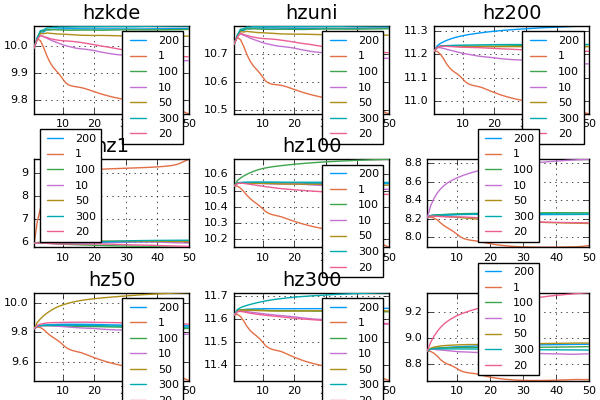

/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [7]:
function objplot(obj; kwargs...)
    p = plot(size=(600,400))
    for (k,v) in ws
        plot!(p, map(obj,v), label=k; kwargs...)
    end
    p
end

plot(
objplot(hzkde, title="hzkde"),
objplot(hzuni, title="hzuni"),
[objplot(w->hz(w, mult), title="hz$mult") for (mult,w) in ws]...)


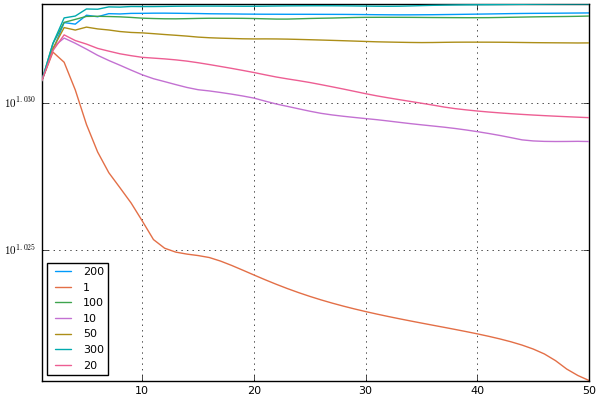

In [35]:
pyplot()
objplot(hzuni, yaxis=:log)
plot!()


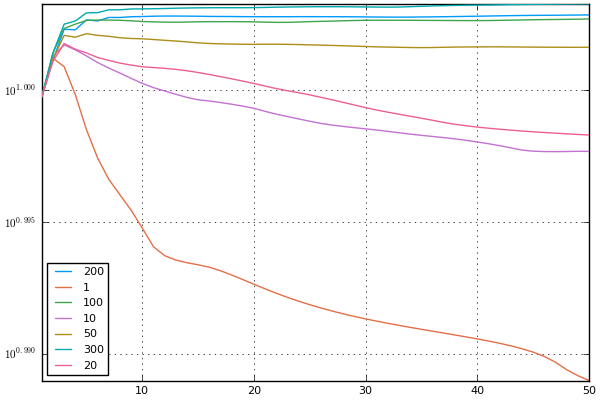

In [37]:
objplot(hzkde, yaxis=:log)

In [45]:
@time wsuni = GynC.gradientascent(hzuni, w0, 20, h)

358.273505 seconds (235.66 M allocations: 25.192 GB, 6.19% gc time)


20-element Array{Any,1}:
 [0.000585538,0.000791013,0.00099229,0.00118941,0.00138242,0.00157136,0.00175627,0.00193719,0.00211417,0.00228724  …  1.85966e-6,1.32515e-6,9.03487e-7,5.81722e-7,3.46721e-7,1.85158e-7,8.35142e-8,2.80803e-8,4.95593e-9,4.95991e-11]    
 [0.000292769,0.000395506,0.00128958,0.00238053,0.00277876,0.00262831,0.00214828,0.00158096,0.00115296,0.00114362  …  0.000491659,0.000650016,0.000811203,0.00097449,0.00113908,0.00130411,0.00146867,0.00163178,0.00179248,0.00194975]  
 [0.000146385,0.000197753,0.00103786,0.00270842,0.00312798,0.00258689,0.00152762,0.000790482,0.000576481,0.00057181  …  0.00024583,0.000325008,0.000583137,0.000852626,0.00112791,0.00140728,0.00168889,0.00197081,0.00225103,0.00252753]
 [7.31923e-5,9.88766e-5,0.00145039,0.00364463,0.00406787,0.00316188,0.00158814,0.000408229,0.00028824,0.000285905  …  0.000122915,0.000162504,0.000291569,0.000654303,0.00103073,0.00141489,0.00180413,0.00219561,0.0025864,0.00297348]  
 [3.65961e-5,4.94383e-5,0.00176576,0.00


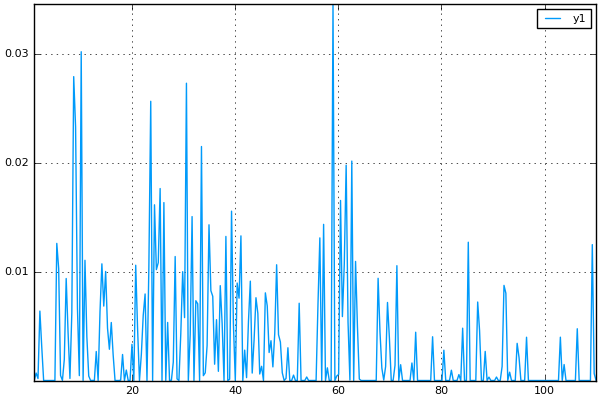

In [48]:
plot(xs,ws[300][20])


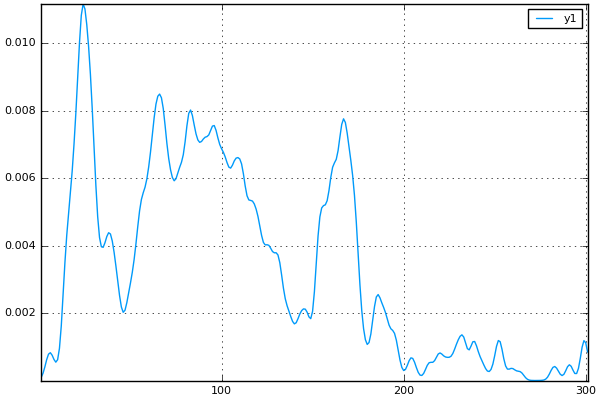

In [86]:
kernel = map(x->pdf(Distributions.Normal(0,2),x), -20:20)
smoothed = conv(ws[300][6], kernel)
plot(smoothed[20:320])


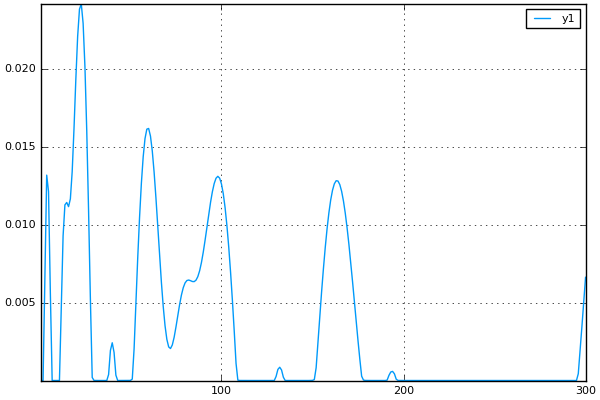

In [72]:
plot(wsuni[end])

In [68]:
Pkg.add("SmoothingKernels")

INFO: Cloning cache of SmoothingKernels from https://github.com/johnmyleswhite/SmoothingKernels.jl.git
INFO: Installing SmoothingKernels v0.0.0
INFO: Package database updated
INFO: METADATA is out-of-date — you may not have the latest version of SmoothingKernels
INFO: Use `Pkg.update()` to get the latest versions of your packages


In [112]:
function varlogrho(wy, zs)
    w  = wy #w = ws[300][end]
    wz = repmat(w, Int(length(zs)/length(ys)))
    L  = GynC.likelihoodmat(zsdict[300], ys, 5)
    rhoz = L * w
    var = dot(wz, (log(rhoz) .^ 2)) - dot(wz, log(rhoz))^2
end

varlogrho (generic function with 1 method)

In [111]:
dot(wr, (log(rhoz) .^ 2)) - dot(wr, log(rhoz))^2

0.7867795573449214